<a href="https://colab.research.google.com/github/ANSHULAGARWAL09/Job-Recommender-System/blob/master/Job_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Job Recommender System**

Connecting to the google drive to get the dataset 

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
path= 'content/gdrive/My Drive/datasets'

The 4 datasets are as follows:
1.The Combined_Jobs_Final.csv file: has the main jobs data(title, description, company, etc.)
2.The Job_Views.csv file: the file with the jobs seeing for the user.
3.The Experience.csv: the file containing the experience from the user.
4.The Positions_Of_Interest.csv: contains the interest the user previously has manifested.

The Process inclused the following steps:
1. Cleaning all files
2. Merging Job_Views.csv, The Experience.csv, The Positions_Of_Interest.csv
3. Getting features from both the files 
4. Finding the Similarity Fucntion for both
5. Getting the top N Recommendations

Importing the Libraries

In [0]:
import pandas as pd
import numpy as np
import csv
import nltk

1.Job Dataset

In [33]:
df_jobs = pd.read_csv("gdrive/My Drive/datasets/Combined_Jobs_Final.csv")
df_jobs.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,NaN,37.685073,-122.400275,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,NaN,34.073384,-118.460439,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [34]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job.ID              84090 non-null  int64  
 1   Provider            84090 non-null  int64  
 2   Status              84090 non-null  object 
 3   Slug                84090 non-null  object 
 4   Title               84090 non-null  object 
 5   Position            84090 non-null  object 
 6   Company             81819 non-null  object 
 7   City                83955 non-null  object 
 8   State.Name          83919 non-null  object 
 9   State.Code          83919 non-null  object 
 10  Address             36 non-null     object 
 11  Latitude            84090 non-null  float64
 12  Longitude           84090 non-null  float64
 13  Industry            267 non-null    object 
 14  Job.Description     84034 non-null  object 
 15  Requirements        0 non-null      float64
 16  Sala

**Exploratory Data Analysis**

In [35]:
df_jobs.isnull().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

Selecting columns for Job Corpus

In [36]:
cols = ['Job.ID']+['Title']+['Position']+ ['Company']+['City']+['Employment.Type']+['Job.Description']
df_jobs =df_jobs[cols]
df_jobs.columns = ['Job.ID', 'Title', 'Position', 'Company','City', 'Empl_type','Job_Description']
df_jobs.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [37]:
# checking for the null values again.
df_jobs.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                135
Empl_type            10
Job_Description      56
dtype: int64

Plotting NA's

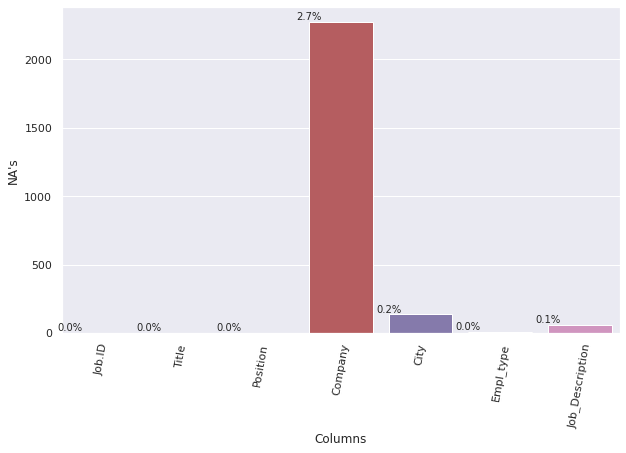

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = df_jobs.columns
y = df_jobs.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/df_jobs.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)

plt.show()

In [39]:
#Selecting Nan for City
df_nan_city = df_jobs[pd.isnull(df_jobs['City'])]
print(df_nan_city.shape)
df_nan_city.head()


(135, 7)


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
3425,142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...
3433,142054,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."


In [40]:
df_nan_city.groupby(['Company'])['City'].count()

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

We see that there are only 9 companies cities that are having NaN values so it must be manually adding their head quarters (by simply searching at google)

In [0]:
#replacing nan with thier headquarters location
df_jobs['Company'] = df_jobs['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')
df_jobs.loc[df_jobs.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
df_jobs.loc[df_jobs.Company == 'Academic Year In America', 'City'] = 'Stamford'
df_jobs.loc[df_jobs.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
df_jobs.loc[df_jobs.Company == 'Driveline Retail', 'City'] = 'Coppell'
df_jobs.loc[df_jobs.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
df_jobs.loc[df_jobs.Company == 'Genesis Health System', 'City'] = 'Davennport'
df_jobs.loc[df_jobs.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
df_jobs.loc[df_jobs.Company == 'St. Francis Hospital', 'City'] = 'New York'
df_jobs.loc[df_jobs.Company == 'Volvo Group', 'City'] = 'Washington'
df_jobs.loc[df_jobs.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'

In [42]:
df_jobs.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                  0
Empl_type            10
Job_Description      56
dtype: int64

In [43]:
#The employement type NA are from Uber so I assume as part-time and full time
df_nan_emp = df_jobs[pd.isnull(df_jobs['Empl_type'])]
df_nan_emp.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
10768,153197,Driving Partner @ Uber,Driving Partner,Uber,San Francisco,NaN,Uber is changing the way the world moves. From...
10769,153198,Driving Partner @ Uber,Driving Partner,Uber,Los Angeles,NaN,Uber is changing the way the world moves. From...
10770,153199,Driving Partner @ Uber,Driving Partner,Uber,Chicago,NaN,Uber is changing the way the world moves. From...
10771,153200,Driving Partner @ Uber,Driving Partner,Uber,Boston,NaN,Uber is changing the way the world moves. From...
10772,153201,Driving Partner @ Uber,Driving Partner,Uber,Ann Arbor,NaN,Uber is changing the way the world moves. From...


In [44]:
df_jobs['Empl_type'].unique()

array(['Part-Time', 'Full-Time/Part-Time', 'Seasonal/Temp', 'Per Diem',
       'Intern', nan, 'Full-Time', 'Contract', 'Temporary/seasonal'],
      dtype=object)

In [45]:
#replacing na values with part time/full time
df_jobs['Empl_type']=df_jobs['Empl_type'].fillna('Full-Time/Part-Time')
df_jobs.groupby(['Empl_type'])['Company'].count()
df_jobs.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


Creating the jobs corpus by combining the columns of position, company, city, emp_type and position

In [46]:
df_jobs["text"] = df_jobs["Position"].map(str) + " " + df_jobs["Company"] +" "+ df_jobs["City"]+ " "+df_jobs['Empl_type']+" "+df_jobs['Job_Description'] +" "+df_jobs['Title']
df_jobs.head(2)

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description,text
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...,Server Tacolicious Palo Alto Part-Time Tacolic...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,Kitchen Staff/Chef Claude Lane San Francisco P...


In [47]:
df_all = df_jobs[['Job.ID', 'text', 'Title']]

df_all = df_all.fillna(" ")

df_all.head()

,Job.ID,text,Title
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [48]:
df_all.shape

(84090, 3)

In [49]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [0]:
df_all['text'] = df_all['text'].apply(clean_txt)   #Cleaning the Job Corpus

In [52]:
df_all.head()  #Cleaned text data 

,Job.ID,text,Title
0,111,server tacolicious palo alto part time tacolic...,Server @ Tacolicious
1,113,kitchen staff chef claude lane san francisco p...,Kitchen Staff/Chef @ Claude Lane
2,117,bartender machka restaurants corp san francisc...,Bartender @ Machka Restaurants Corp.
3,121,server teriyaki house brisbane part time serve...,Server @ Teriyaki House
4,127,kitchen staff chef rosa mexicano sunset los an...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [53]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
tfidf_jobid

<84090x50754 sparse matrix of type '<class 'numpy.float64'>'
	with 8263698 stored elements in Compressed Sparse Row format>

**Creating the User Corpus**

In [54]:
df_job_view = pd.read_csv("gdrive/My Drive/datasets/Job_Views.csv")
df_job_view.head(2)

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC


In [55]:
#We will use only the columns 'Applicant.ID', 'Job.ID', 'Position', 'Company','City'
df_job_view = df_job_view[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
df_job_view["select_pos_com_city"] = df_job_view["Position"].map(str) + "  " + df_job_view["Company"] +"  "+ df_job_view["City"]
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].map(str).apply(clean_txt)
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].str.lower()
df_job_view = df_job_view[['Applicant.ID','select_pos_com_city']]
df_job_view.head()  

,Applicant.ID,select_pos_com_city
0,10000,cashier valet need wallypark newark
1,10000,macys seasonal retail fragrance cashier garden...
2,10001,part time showroom sales cashier grizzly indus...
3,10002,event specialist part time advantage sales mar...
4,10002,bonefish kitchen staff bonefish grill greenville


In [56]:
#Experience Dataset
df_experience = pd.read_csv("gdrive/My Drive/datasets/Experience.csv")
df_experience.head(2)

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC


In [57]:
#taking only Position
df_experience= df_experience[['Applicant.ID','Position.Name']]
#cleaning the text
df_experience['Position.Name'] = df_experience['Position.Name'].map(str).apply(clean_txt)
df_experience.head()

,Applicant.ID,Position.Name
0,10001,account manager sales administration quality a...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper


In [58]:
df_experience =  df_experience.sort_values(by='Applicant.ID')
df_experience = df_experience.fillna(" ")
df_experience.head()

,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer uloop blog
3759,3,market intern
3758,3,server
3757,3,prep cook


In [59]:
#adding same rows to a single row
df_experience = df_experience.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
df_experience.head(5)

#3 applications 100001 in sigle line so we need to join them

,Applicant.ID,Position.Name
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


In [60]:
#Position of interest
df_poi =  pd.read_csv("gdrive/My Drive/datasets/Positions_Of_Interest.csv", sep=',')
df_poi = df_poi.sort_values(by='Applicant.ID')
df_poi.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [61]:
df_poi = df_poi.drop('Updated.At', 1)
df_poi = df_poi.drop('Created.At', 1)

#cleaning the text
df_poi['Position.Of.Interest']=df_poi['Position.Of.Interest'].map(str).apply(clean_txt)
df_poi = df_poi.fillna(" ")
df_poi.head(10)

,Applicant.ID,Position.Of.Interest
6437,96,server
1156,153,barista
1155,153,host
1154,153,server
1158,153,sales rep
1157,153,customer service rep
1952,256,host
1957,256,production area
1956,256,sales rep
1955,256,customer service rep


In [62]:
df_poi = df_poi.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
df_poi.head()

,Applicant.ID,Position.Of.Interest
0,96,server
1,153,barista host server sales rep customer service...
2,256,host production area sales rep customer servic...
3,438,customer service rep barista host server
4,568,receptionist customer service rep book keeper


Creating the final user dataset by merging all the users datasets

In [63]:
df_jobs_exp = df_job_view.merge(df_experience, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp = df_jobs_exp.fillna(' ')
df_jobs_exp = df_jobs_exp.sort_values(by='Applicant.ID')
df_jobs_exp.head()

,Applicant.ID,select_pos_com_city,Position.Name
12370,2,,volunteer writer uloop blog
12371,3,,market intern server prep cook
12372,6,,project assistant
12373,8,,deli clerk server cashier food prep order taker
12374,11,,cashier


In [64]:
#Now Merging position of interest 
df_jobs_exp_poi = df_jobs_exp.merge(df_poi, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp_poi = df_jobs_exp_poi.fillna(' ')
df_jobs_exp_poi = df_jobs_exp_poi.sort_values(by='Applicant.ID')
df_jobs_exp_poi.head()


,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest
0,2,,volunteer writer uloop blog,
1,3,,market intern server prep cook,
2,6,,project assistant,
3,8,,deli clerk server cashier food prep order taker,
4,11,,cashier,


In [65]:
df_jobs_exp_poi["text"] = df_jobs_exp_poi["select_pos_com_city"].map(str) + df_jobs_exp_poi["Position.Name"] +" "+ df_jobs_exp_poi["Position.Of.Interest"]

df_jobs_exp_poi.head()  #Combining all the columns

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest,text
0,2,,volunteer writer uloop blog,,volunteer writer uloop blog
1,3,,market intern server prep cook,,market intern server prep cook
2,6,,project assistant,,project assistant
3,8,,deli clerk server cashier food prep order taker,,deli clerk server cashier food prep order tak...
4,11,,cashier,,cashier


In [66]:
df_final_person= df_jobs_exp_poi[['Applicant.ID','text']]
df_final_person.head() #Only application id and text

,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [67]:
df_final_person.columns = ['Applicant_id','text']
df_final_person.head()

,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [68]:
df_final_person['text'] = df_final_person['text'].apply(clean_txt)
df_final_person.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


In [69]:
u = 326
index = np.where(df_final_person['Applicant_id'] == u)[0][0]
user_q = df_final_person.iloc[[index]]
user_q  # For test the recommender ID is 326

,Applicant_id,text
186,326,java developer


**The recommender systems**

There are 4 Content based Recommenders System:
1. tfidf
2. CountVectoriszer
3. Spacy
4. KNN

In [0]:
from sklearn.metrics.pairwise import cosine_similarity  #Computing cosine similarity using tfidf
user_tfidf = tfidf_vectorizer.transform(user_q['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)

In [0]:
output2 = list(cos_similarity_tfidf)

In [0]:
def get_recommendation(top, df_all, scores):   #Functions to get top recommendations order by score
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID',  'title', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = u
      recommendation.at[count, 'JobID'] = df_all['Job.ID'][i]
      recommendation.at[count, 'title'] = df_all['Title'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

In [73]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]  #The top recommendations using TF-IDF
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,303112,Java Developer @ TransHire,0.749478
1,326,294684,Java Developer @ Kavaliro,0.740886
2,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.737007
3,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.671667
4,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.645037
5,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.625532
6,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.592291
7,326,245753,Java Administrator @ ConsultNet,0.530231
8,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.510534
9,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.486789


In [74]:
from sklearn.feature_extraction.text import CountVectorizer   #Using Count Vectoriser
count_vectorizer = CountVectorizer()

count_jobid = count_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
count_jobid

<84090x50754 sparse matrix of type '<class 'numpy.int64'>'
	with 8263698 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
user_count = count_vectorizer.transform(user_q['text'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)

In [0]:
output2 = list(cos_similarity_countv)

In [77]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]  #Top recommendations using Count Vectoriser
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,303112,Java Developer @ TransHire,0.635001
1,326,294684,Java Developer @ Kavaliro,0.600245
2,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.571726
3,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.496907
4,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.481757
5,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.454673
6,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.406017
7,326,245753,Java Administrator @ ConsultNet,0.378968
8,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.363216
9,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.323381


**Recomendation using Spacy**

In [0]:
import spacy

In [28]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
nlp = spacy.load('en_core_web_lg')

Transform the copurs text to the spacy's documents

In [78]:
%%time 
list_docs = []
for i in range(len(df_all)):
  doc = nlp("u'" + df_all['text'][i] + "'")
  list_docs.append((doc,i))
print(len(list_docs))


84090
CPU times: user 42min 21s, sys: 25.4 s, total: 42min 47s
Wall time: 42min 50s


In [0]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim

In [80]:
user_q.text[186]

'java developer'

In [81]:
%%time
df3 = calculateSimWithSpaCy(nlp, df_all, user_q.text[186], n=15)

CPU times: user 1min 3s, sys: 513 ms, total: 1min 3s
Wall time: 1min 3s


In [0]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(10)

In [0]:
df_recom_spacy.reset_index(inplace=True)

In [0]:
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

In [85]:
#Top Recommendations using Spacy
get_recommendation(index_spacy, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,250216,Microstrategy Developer @ Kavaliro,0.698317
1,326,294489,Magento Developer (ONSITE) @ Creative Circle,0.654219
2,326,254979,Director (Interim),0.633758
3,326,264113,Pharmacist-St. Augustine,0.633758
4,326,144460,Technology Sales Specialist,0.633758
5,326,308537,Account Manager - Sales,0.633758
6,326,264110,Licensed Practical Nurse - Greensboro (PRN),0.633758
7,326,178053,Retail Sales Associate – Part-Time,0.633758
8,326,308538,Account Manager - Sales,0.633758
9,326,264106,Licensed Practical Nurse - Columbus (PRN),0.633758


**Using KNN**

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 11
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(tfidf_jobid)
NNs = KNN.kneighbors(user_tfidf, return_distance=True)

In [87]:
NNs[0][0][1:]

array([0.71988065, 0.72524925, 0.81034882, 0.84257062, 0.86541138,
       0.90300462, 0.96929812, 0.98940985, 1.        , 1.        ])

In [88]:
#Top Recommendatons using KNN
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(top, df_all, index_score)

,ApplicantID,JobID,title,score
0,326,294684,Java Developer @ Kavaliro,0.719881
1,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.725249
2,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.810349
3,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.842571
4,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.865411
5,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.903005
6,326,245753,Java Administrator @ ConsultNet,0.969298
7,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.98941
8,326,253863,Resident Assistant,1
9,326,246058,Dietary Aide,1


**WordCloud**

In [0]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
bunch_text = " ".join(text for text in df_all.tail(10000).text)

In [0]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

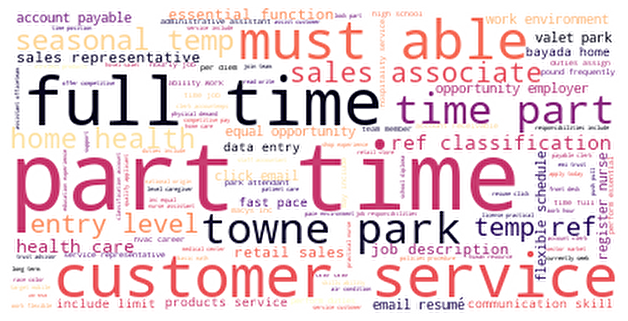

In [92]:
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [93]:
!wget https://microventures.com/wp-content/uploads/team-1697987_640.png >img1

--2020-04-23 21:39:56--  https://microventures.com/wp-content/uploads/team-1697987_640.png
Resolving microventures.com (microventures.com)... 146.148.53.236
Connecting to microventures.com (microventures.com)|146.148.53.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31568 (31K) [image/png]
Saving to: ‘team-1697987_640.png’

team-1697987_640.pn 100%[===================>]  30.83K  --.-KB/s    in 0.04s   

2020-04-23 21:39:56 (855 KB/s) - ‘team-1697987_640.png’ saved [31568/31568]



In [0]:
!mv team-1697987_640.png wf.png

In [0]:
img = Image.open("wf.png").convert('RGBA')
x = np.array(img)
r, g, b, a = np.rollaxis(x, axis = -1)
r[a == 0] = 255
g[a == 0] = 255
b[a == 0] = 255
x = np.dstack([r, g, b, a])
img = Image.fromarray(x, 'RGBA')

In [0]:
thresh = 200
fn = lambda x : 255 if x <= thresh else 0
wf_mask = img.convert('L').point(fn, mode='1')
wf_mask = np.array(wf_mask)

In [0]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [0]:
transformed_wf_mask = np.ndarray((wf_mask.shape[0],wf_mask.shape[1]), np.int32)

for i in range(len(wf_mask)):
    transformed_wf_mask[i] = list(map(transform_format, wf_mask[i]))

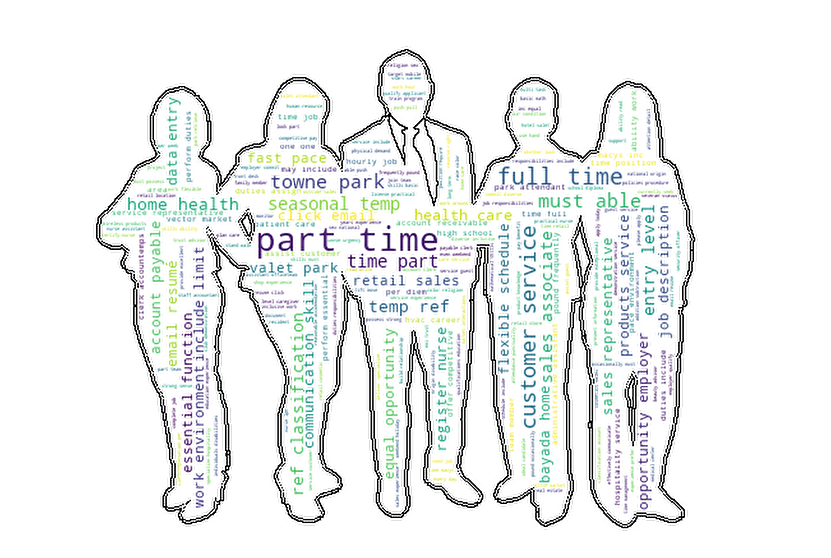

In [99]:
wc = WordCloud(background_color="white", mask=transformed_wf_mask,
               stopwords=stopwords, contour_width=.1, contour_color='black')

# Generate a wordcloud
wc.generate(bunch_text)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation="sinc")
plt.axis("off")
plt.show()